In [1]:
import seaborn as sns
import json
import time
import re
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
energy=pd.read_csv('town_data_2',index_col=0)
census=pd.read_csv('town_census_data',index_col=0)

In [3]:
#add 'town, ST' column to energy data
name_col=['{}, {}'.format(row['name'],row['state']) for i,row in energy.iterrows()]
energy['town']=name_col

In [4]:
energy['town']=name_col

In [5]:
census.rename(columns={'name':'town'}, inplace=True)

In [6]:
#drop duplicate columns
census.drop_duplicates(inplace=True)
energy.drop_duplicates(inplace=True)

In [7]:
drop_me=[]
for i,row in energy.iterrows():
    if row.town not in census['town'].values:
        drop_me.append(row['town'])

In [8]:
# Drop columns not in census data
energy=energy[energy.town!='Bethel Park, PA']
energy=energy[energy.town!='Southampton, PA']
energy=energy[energy.town!='Columbus, GA']
energy=energy[energy.town!='Fort Mill, SC']

In [9]:
#make final dataset
towny = pd.merge(energy, census, on=['town','town'])

In [10]:
#set town to index
towny.set_index('town',inplace=True)

In [11]:
#convert strings to ints/floats (only run once)
# towny.edu=towny.edu.map(lambda u:float(u[:4]))
# towny.poverty=towny.poverty.map(lambda u:float(u[:-1]))
# towny.income=towny.income.map(lambda u:int(u[:-4]+u[-3:]))

In [12]:
#drop scarsdale bc no income
towny.drop('Scarsdale, NY' , axis=0,inplace=True)

In [13]:
#drop name column(used in index)
towny.drop(['name','state'],axis=1,inplace=True)

In [14]:
towny.head()

,biz,com_elec_ghg,com_gas_1kdol,com_gas_ghg,com_gas_mcf,houses,ind,ind_elec_ghg,ind_gas_1kdol,ind_gas_ghg,ind_gas_mcf,pop,res_elec_ghg,res_gas_1kdol,res_gas_ghg,res_gas_mcf,age,edu,income,poverty
town,,,,,,,,,,,,,,,,,,,,
"Bismarck, ND",927.0,337550656.0,4000.0,88869152.0,740313.0,29680.0,290.0,262308579.0,2668.0,122239228.0,1018298.0,68981.0,271312168.0,11497.0,188394738.0,1569398.0,37.1,93.1%,"61,477",9.5%
"Ridgewood, NJ",653.0,202329017.0,2790.0,46272451.0,385467.0,8335.0,88.0,4662251.0,133.0,2425500.0,20205.0,25430.0,155528162.0,7578.0,121772514.0,1014410.0,41.3,97.1%,"162,011",4.4%
"Natchez, MS",513.0,154290472.0,1013.0,16820605.0,140122.0,6235.0,179.0,13753718.0,272.0,7518503.0,62632.0,15345.0,140880520.0,2100.0,25006228.0,208311.0,39.7,86.5%,"28,089",35.9%
"Southaven, MS",630.0,582120118.0,2371.0,39360611.0,327888.0,18386.0,134.0,89281642.0,1674.0,46200938.0,384871.0,51816.0,451151482.0,6928.0,82754153.0,689373.0,36.0,88.5%,"60,093",11.1%
"Garfield, NJ",535.0,118919226.0,2349.0,38970852.0,324642.0,10987.0,159.0,25168153.0,719.0,13093537.0,109074.0,31456.0,140232090.0,5885.0,94566190.0,787771.0,36.3,84.4%,"54,063",17.7%


# EDA

In [15]:
towny.columns

Index(['biz', 'com_elec_ghg', 'com_gas_1kdol', 'com_gas_ghg', 'com_gas_mcf',
       'houses', 'ind', 'ind_elec_ghg', 'ind_gas_1kdol', 'ind_gas_ghg',
       'ind_gas_mcf', 'pop', 'res_elec_ghg', 'res_gas_1kdol', 'res_gas_ghg',
       'res_gas_mcf', 'age', 'edu', 'income', 'poverty'],
      dtype='object')

''

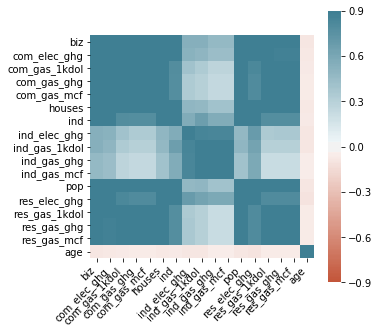

In [16]:
data=towny.dropna()

plt.figure(figsize=(5,5))
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-.9, vmax=.9, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
;

count      1073.000000
mean      62995.410997
std       24044.427331
min       20157.000000
25%       45186.000000
50%       57610.000000
75%       75647.000000
max      181360.000000
Name: income, dtype: float64


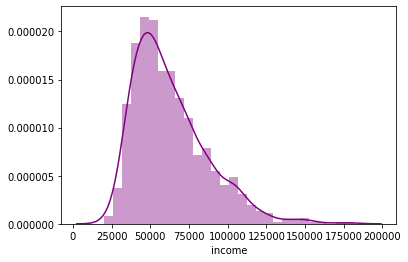

In [21]:
category='income'
print(towny[category].describe())
sns.distplot(towny[category].dropna(),color='purple')

In [22]:
# towny['income'].sort_values(ascending=False)

In [23]:
#choosing possible target params
#make 0-50,50-100,100+ categories
target_income=towny.income.map(lambda q: 1 if q<=50000 
                            else 2 if (q>50000)&(q<=100000) 
                            else 3 if q>100000 else 0)
target_age=towny.age.map(lambda p: 1 if p<=36
                            else 2 if (p>36)&(p<=40) 
                            else 3 if p>40 else 0)
target_edu=towny.edu.map(lambda l: 1 if l<=87
                            else 2 if (l>87)&(l<=93) 
                            else 3 if l>93 else 0)
target_poverty=towny.poverty.map(lambda m: 1 if m<=9
                            else 2 if (m>9)&(m<=17) 
                            else 3 if m>17 else 0)
targets=pd.DataFrame([target_income,target_age,target_edu,target_poverty]).transpose()

In [24]:
towny.dropna(axis=0,inplace=True)
targets=targets.loc[towny.index.tolist()]

In [25]:
towny.to_csv('towny_df')

In [30]:
targets.to_csv('target_df')

In [27]:
targets

,income,age,edu,poverty
town,,,,
"Bismarck, ND",2,2,3,2
"Ridgewood, NJ",3,3,3,1
"Natchez, MS",1,2,1,3
"Southaven, MS",2,1,2,2
"Garfield, NJ",2,2,1,3
"Strongsville, OH",2,3,3,1
"Holly Springs, NC",3,1,3,1
"Ridgefield, CT",3,3,3,1
"Orlando, FL",1,1,2,3


In [28]:
towny.dropna(axis=0,inplace=True)

In [238]:
towny.shape

(1065, 20)

In [239]:
targets

,income,age,edu,poverty
town,,,,
"Bismarck, ND",2,2,3,2
"Ridgewood, NJ",3,3,3,1
"Natchez, MS",1,2,1,3
"Southaven, MS",2,1,2,2
"Garfield, NJ",2,2,1,3
"Strongsville, OH",2,3,3,1
"Holly Springs, NC",3,1,3,1
"Williamsburg, VA",2,1,3,3
"Ridgefield, CT",3,3,3,1


In [248]:
drop_me=[]
for i,row in targets.iterrows():
    print(row.index)
#     if row.index not in towny.index():
#         drop_me.append(row.index)

AttributeError: 'Series' object has no attribute 'index_col'

In [250]:
towny.index

Index(['Bismarck, ND', 'Ridgewood, NJ', 'Natchez, MS', 'Southaven, MS',
       'Garfield, NJ', 'Strongsville, OH', 'Holly Springs, NC',
       'Ridgefield, CT', 'Orlando, FL', 'Kenosha, WI',
       ...
       'Sheboygan, WI', 'Piscataway, NJ', 'Cocoa, FL', 'Cartersville, GA',
       'Chatsworth, GA', 'Grandville, MI', 'New Britain, CT', 'Northville, MI',
       'Waltham, MA', 'Butler, PA'],
      dtype='object', name='town', length=1065)

In [31]:
#drop nan towns from target
targets=targets.loc[towny.index.tolist()]

In [39]:
#divide all energy data by population
norm_pop_town={}
for col in towny.columns:
    norm_pop_town['{}'.format(col)]=towny[col]/towny['pop']
norm_towns=pd.DataFrame(norm_pop_town)
norm_towns.drop('pop',axis=1,inplace=True)

In [46]:
towny.head()

,biz,com_elec_ghg,com_gas_1kdol,com_gas_ghg,com_gas_mcf,houses,ind,ind_elec_ghg,ind_gas_1kdol,ind_gas_ghg,ind_gas_mcf,pop,res_elec_ghg,res_gas_1kdol,res_gas_ghg,res_gas_mcf,age,edu,income,poverty
town,,,,,,,,,,,,,,,,,,,,
"Bismarck, ND",927.0,337550656.0,4000.0,88869152.0,740313.0,29680.0,290.0,262308579.0,2668.0,122239228.0,1018298.0,68981.0,271312168.0,11497.0,188394738.0,1569398.0,37.1,93.1,61477,9.5
"Ridgewood, NJ",653.0,202329017.0,2790.0,46272451.0,385467.0,8335.0,88.0,4662251.0,133.0,2425500.0,20205.0,25430.0,155528162.0,7578.0,121772514.0,1014410.0,41.3,97.1,162011,4.4
"Natchez, MS",513.0,154290472.0,1013.0,16820605.0,140122.0,6235.0,179.0,13753718.0,272.0,7518503.0,62632.0,15345.0,140880520.0,2100.0,25006228.0,208311.0,39.7,86.5,28089,35.9
"Southaven, MS",630.0,582120118.0,2371.0,39360611.0,327888.0,18386.0,134.0,89281642.0,1674.0,46200938.0,384871.0,51816.0,451151482.0,6928.0,82754153.0,689373.0,36.0,88.5,60093,11.1
"Garfield, NJ",535.0,118919226.0,2349.0,38970852.0,324642.0,10987.0,159.0,25168153.0,719.0,13093537.0,109074.0,31456.0,140232090.0,5885.0,94566190.0,787771.0,36.3,84.4,54063,17.7


In [44]:
['biz', 'com_elec_ghg', 'com_gas_1kdol', 'com_gas_ghg', 'com_gas_mcf',
       'houses', 'ind', 'ind_elec_ghg', 'ind_gas_1kdol', 'ind_gas_ghg',
       'ind_gas_mcf', 'pop', 'res_elec_ghg', 'res_gas_1kdol', 'res_gas_ghg',
       'res_gas_mcf', 'age', 'edu', 'income', 'poverty']

In [45]:
norm_towns.to_csv('normalized_towns')

In [ ]:
norm_build_town={}
for col in towny.columns:
    norm_pop_town['{}'.format(col)]=towny[col]/towny['pop']
norm_towns=pd.DataFrame(norm_pop_town)
norm_towns.drop('pop',axis=1,inplace=True)

In [49]:
norm_building_town={}
biz=['com_elec_ghg','com_gas_1kdol','com_gas_ghg','com_gas_mcf',]
ind=['ind_elec_ghg','ind_gas_1kdol','ind_gas_ghg','ind_gas_mcf',]
res=['res_elec_ghg','res_gas_1kdol','res_gas_ghg','res_gas_mcf']
for col in biz:
    norm_building_town['{}'.format(col)]=norm_towns[col]/towny['biz']
for col in ind:
    norm_building_town['{}'.format(col)]=norm_towns[col]/towny['ind']
for col in res:
    norm_building_town['{}'.format(col)]=norm_towns[col]/towny['houses']

norm_buildings=pd.DataFrame(norm_building_town)
norm_buildings=norm_buildings.applymap(lambda x: 0 if x==np.inf else x,)

In [57]:
norm_buildings.to_csv('norm_buildings_df')

In [54]:
norm_buildings.describe()

,com_elec_ghg,com_gas_1kdol,com_gas_ghg,com_gas_mcf,ind_elec_ghg,ind_gas_1kdol,ind_gas_ghg,ind_gas_mcf,res_elec_ghg,res_gas_1kdol,res_gas_ghg,res_gas_mcf
count,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1.065000e+03,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000
mean,inf,inf,inf,inf,55.215386,9.998945e-04,21.962581,0.182957,0.923293,0.000022,0.272461,0.002270
std,NaN,NaN,NaN,NaN,238.929302,4.106757e-03,75.915948,0.632419,2.404977,0.000045,0.530577,0.004420
min,0.049941,0.000000,0.000000,0.000000,0.008362,1.439294e-07,0.002919,0.000024,0.000842,0.000000,0.000000,0.000000
25%,4.121165,0.000042,0.660847,0.005505,3.832191,9.083865e-05,1.951478,0.016257,0.202807,0.000005,0.059083,0.000492
50%,7.860269,0.000099,1.687569,0.014058,10.545926,2.507449e-04,5.535560,0.046113,0.418305,0.000012,0.146696,0.001222
75%,14.542303,0.000179,3.058582,0.025479,35.770120,6.914319e-04,15.603120,0.129980,0.850325,0.000022,0.295583,0.002462
max,inf,inf,inf,inf,6259.331435,1.082005e-01,1756.005695,14.628702,41.147291,0.000858,9.809639,0.081718


In [56]:
norm_buildings=norm_buildings.applymap(lambda x: 0 if x==np.inf else x,)

In [ ]:
norm_towns

In [91]:
towny['biz'].mean()

1301.2328638497652

## Average town usage

In [158]:
summer=towny['com_elec_ghg']+towny['com_gas_ghg']+towny['ind_elec_ghg']+towny['ind_gas_ghg']+towny['res_elec_ghg']+towny['res_gas_ghg']
biz_1000_mean=(((towny['com_elec_ghg']+towny['com_gas_ghg'])/(summer))).map(lambda x: 0 if x==np.inf else x,).mean()
ind_1000_mean=(((towny['ind_elec_ghg']+towny['ind_gas_ghg'])/(summer))).map(lambda x: 0 if x==np.inf else x,).mean()
res_1000_mean=(((towny['res_elec_ghg']+towny['res_gas_ghg'])/(summer))).map(lambda x: 0 if x==np.inf else x,).mean()
ind_1000_mean

0.23284181251392705

In [159]:
per_1000=[ind_1000_mean,biz_1000_mean,res_1000_mean]
type_=['Industry','Business','Residential']
nums=pd.DataFrame(per_1000,index=type_,columns=['%Carbon Emission'])

In [410]:
towny.head()

,biz,com_elec_ghg,com_gas_1kdol,com_gas_ghg,com_gas_mcf,houses,ind,ind_elec_ghg,ind_gas_1kdol,ind_gas_ghg,ind_gas_mcf,pop,res_elec_ghg,res_gas_1kdol,res_gas_ghg,res_gas_mcf,age,edu,income,poverty
town,,,,,,,,,,,,,,,,,,,,
"Bismarck, ND",927.0,337550656.0,4000.0,88869152.0,740313.0,29680.0,290.0,262308579.0,2668.0,122239228.0,1018298.0,68981.0,271312168.0,11497.0,188394738.0,1569398.0,37.1,93.1,61477,9.5
"Ridgewood, NJ",653.0,202329017.0,2790.0,46272451.0,385467.0,8335.0,88.0,4662251.0,133.0,2425500.0,20205.0,25430.0,155528162.0,7578.0,121772514.0,1014410.0,41.3,97.1,162011,4.4
"Natchez, MS",513.0,154290472.0,1013.0,16820605.0,140122.0,6235.0,179.0,13753718.0,272.0,7518503.0,62632.0,15345.0,140880520.0,2100.0,25006228.0,208311.0,39.7,86.5,28089,35.9
"Southaven, MS",630.0,582120118.0,2371.0,39360611.0,327888.0,18386.0,134.0,89281642.0,1674.0,46200938.0,384871.0,51816.0,451151482.0,6928.0,82754153.0,689373.0,36.0,88.5,60093,11.1
"Garfield, NJ",535.0,118919226.0,2349.0,38970852.0,324642.0,10987.0,159.0,25168153.0,719.0,13093537.0,109074.0,31456.0,140232090.0,5885.0,94566190.0,787771.0,36.3,84.4,54063,17.7


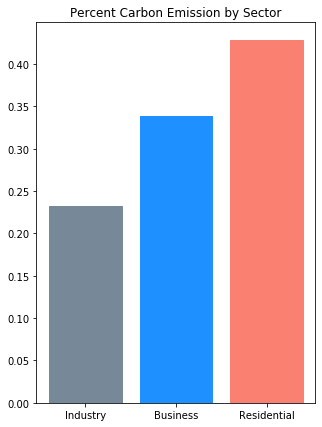

In [160]:
# fig=sns.barplot(x=nums.index,y=nums['%Carbon Emission']).
plt.figure(figsize=(5,7))
barlist=plt.bar(nums.index,nums['%Carbon Emission'])
# plt.plot(fig)
barlist[0].set_color('lightslategray')
barlist[1].set_color('dodgerblue')
barlist[2].set_color('salmon')
plt.title('Percent Carbon Emission by Sector')
plt.show()

## Define income levels

count      1065.000000
mean      63021.639437
std       24120.359003
min       20157.000000
25%       45057.000000
50%       57610.000000
75%       76007.000000
max      181360.000000
Name: income, dtype: float64


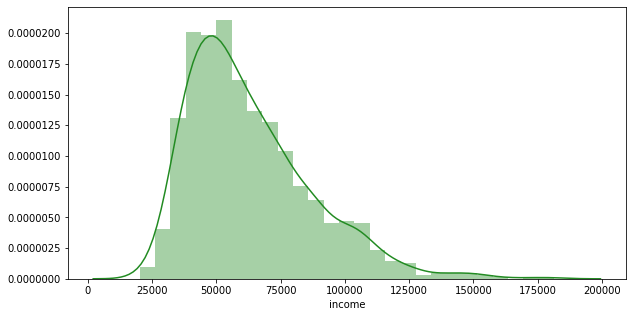

In [177]:
category='income'
plt.figure(figsize=(10,5))
print(towny[category].describe())
sns.distplot(towny[category].dropna(),color='forestgreen')


In [224]:
towny['income'].mode()

0      39885
1      47083
2      53794
3      57269
4      57660
5      65349
6      68068
7      83304
8      99050
9     100305
10    126000
dtype: int64

In [384]:
np.quantile(towny['income'],.5)

57610.0

In [ ]:
1778
22

In [313]:
county=.22725
for i in range(5):
    print(np.quantile(towny['income'],county*i))

20157.0
43976.966
54811.32400000001
70032.79400000001
99998.00800000002


In [317]:
#create bins
cut1=20157.0
cut2=43976.966
cut3=54811.32400000001
cut4=70032.79400000001
range_income=towny.income.map(lambda q: 1 if q<= cut2
                            else 2 if (q>cut2)&(q<=cut3)
                            else 3 if (q>cut3)&(q<=cut4)
                            else 4 if (q>cut4)&(q<=100000)
                            else 5 if (q>100000)&(q<=139836)
                            else 6 if q>139836 else 0)

In [350]:
range_income.value_counts()

4    242
3    242
2    242
1    242
5     86
6     11
Name: income, dtype: int64

In [343]:
income_dist=pd.DataFrame([range_income,towny['income']],index=['target','income']).transpose()

In [345]:
poor=income_dist.loc[income_dist['target']==1]
low_mid=income_dist.loc[income_dist['target']==2]
mid=income_dist.loc[income_dist['target']==3]
up_mid=income_dist.loc[income_dist['target']==4]
rich=income_dist.loc[income_dist['target']==5]
one_percent=income_dist.loc[income_dist['target']==6]

In [360]:
rich_plot=pd.concat([rich,rich,rich],axis=0)

In [ ]:
rich_plot

In [361]:
rich_plot.shape

(258, 2)

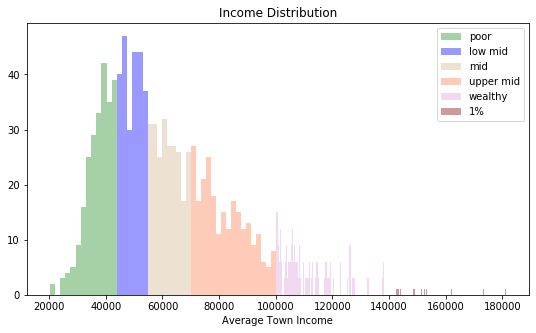

In [383]:
plt.figure(figsize=(9,5))
sns.distplot(poor['income'].dropna(),color='forestgreen',kde=False,bins=13,label='poor')
sns.distplot(low_mid['income'].dropna(),color='b',kde=False,bins=6,label='low mid')
sns.distplot(mid['income'].dropna(),color='tan',kde=False,bins=9,label='mid')
sns.distplot(up_mid['income'].dropna(),color='coral',kde=False,bins=17,label='upper mid')
sns.distplot(rich_plot['income'].dropna(),color='plum',kde=False,bins=90,label='wealthy')
sns.distplot(one_percent['income'].dropna(),color='darkred',kde=False,bins=100,label='1%')
plt.xlabel('Average Town Income')
plt.title('Income Distribution')
plt.legend()

In [348]:
poor

,target,income
town,,
"Natchez, MS",1,28089
"Logansport, IN",1,35603
"Elyria, OH",1,42067
"Hopkinsville, KY",1,37479
"Jonesboro, GA",1,31343
"Sevierville, TN",1,36884
"Greenville, NC",1,36496
"Rocky Mount, NC",1,37607
"Ames, IA",1,42755


In [352]:
income_dist.shape

(1065, 2)

In [353]:
income_dist.to_csv('binned_income')

## 2-way split

In [386]:
mean_=63021.64
median_=57610

In [387]:
income_by_mean=towny.income.map(lambda q: 1 if q<= mean_
                              else 2 if q>mean_ else 0)
income_by_median=towny.income.map(lambda q: 1 if q<= median_
                              else 2 if q>median_ else 0)

In [393]:
income_med_split=pd.DataFrame([income_by_median,towny['income']]
                              ,index=['target','income']).transpose()
income_mean_split=pd.DataFrame([income_by_mean,towny['income']]
                              ,index=['target','income']).transpose()

In [392]:
income_med_split['target'].value_counts()

1    533
2    532
Name: target, dtype: int64

In [394]:
income_mean_split['target'].value_counts()

1    625
2    440
Name: target, dtype: int64

In [405]:
income_binary=pd.DataFrame([income_by_median,
                            income_by_mean,
                            towny['income']],
                            index=['median','mean','income']).transpose()

In [401]:
income_binary.to_csv('incomes binary split')

In [408]:
income_binary.columns

Index(['median', 'mean', 'income'], dtype='object')

In [414]:
[income_dist.groupby('target').mean()]

[               income
 target               
 1        37446.351240
 2        49381.041322
 3        62057.057851
 4        81948.975207
 5       111103.406977
 6       154678.545455]

In [418]:
# summer=towny['com_elec_ghg']+towny['com_gas_ghg']+towny['ind_elec_ghg']+towny['ind_gas_ghg']+towny['res_elec_ghg']+towny['res_gas_ghg']
biz=18
ind=32
res=21
trans=28
ind_1000_mean

0.23284181251392705

In [421]:
per_1000=[ind,biz,res,trans]
type_=['Industry','Business','Residential','Transportation']
nums=pd.DataFrame(per_1000,index=type_,columns=['%Energy by Sector'])

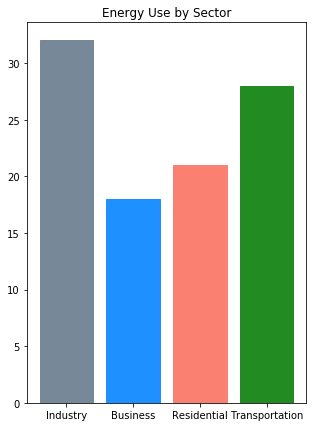

In [422]:
# fig=sns.barplot(x=nums.index,y=nums['%Carbon Emission']).
plt.figure(figsize=(5,7))
barlist=plt.bar(nums.index,nums['%Energy by Sector'])
# plt.plot(fig)
barlist[0].set_color('lightslategray')
barlist[1].set_color('dodgerblue')
barlist[2].set_color('salmon')
barlist[3].set_color('forestgreen')
barlist
plt.title('Energy Use by Sector')
plt.show()

In [ ]:
Industrial=32%
Transportation	28%
Residential	21%
Commercial	18%